<a href="https://colab.research.google.com/github/austintaps/customer-churn/blob/main/boostmodel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [289]:
from google.colab import drive
#drive.mount("/content/drive")
#drive.mount("/content/drive", force_remount=true)

In [290]:
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [291]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score,roc_auc_score,make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix
import xgboost as xgb
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
%matplotlib inline
import param,numbergen

In [292]:
customer=pd.read_csv('/content/drive/My Drive/Colab Notebooks/datasets_13996_18858_WA_Fn-UseC_-Telco-Customer-Churn (3).csv')

In [293]:
customer.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


PREPAIRING DATA FOR THE XGBOOST

In [294]:
customer.drop('customerID',axis='columns',inplace=True)

In [295]:
customer.TotalCharges.values

array(['29.85', '1889.5', '108.15', ..., '346.45', '306.6', '6844.5'],
      dtype=object)

In [296]:
pd.to_numeric(customer.TotalCharges,errors='coerce').isnull()

0       False
1       False
2       False
3       False
4       False
        ...  
7038    False
7039    False
7040    False
7041    False
7042    False
Name: TotalCharges, Length: 7043, dtype: bool

In [297]:
customer[pd.to_numeric(customer.TotalCharges,errors='coerce').isnull()]

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,,No
753,Male,0,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,,No
936,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,,No
1082,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,,No
1340,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,,No
3331,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,,No
3826,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,,No
4380,Female,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,,No
5218,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,,No
6670,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,,No


In [298]:
customer.shape

(7043, 20)

In [299]:
customer.iloc[488].TotalCharges

' '

In [300]:
customer[customer.TotalCharges!=' '].shape

(7032, 20)

In [301]:
customer1 = customer[customer.TotalCharges!=' ']
customer1.shape


(7032, 20)

In [302]:
customer1.dtypes

gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [303]:
customer1.TotalCharges = pd.to_numeric(customer1.TotalCharges)

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [304]:
customer1.TotalCharges.values

array([  29.85, 1889.5 ,  108.15, ...,  346.45,  306.6 , 6844.5 ])

In [305]:
customer1[customer1.Churn=='No']

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
6,Male,0,No,Yes,22,Yes,Yes,Fiber optic,No,Yes,No,No,Yes,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.40,No
7,Female,0,No,No,10,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,No,Mailed check,29.75,301.90,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7037,Female,0,No,No,72,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,Yes,Bank transfer (automatic),21.15,1419.40,No
7038,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.50,No
7039,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.90,No
7040,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No


In [306]:
def print_unique_col_values(df):
       for column in df:
            if df[column].dtypes=='object':
                print(f'{column}: {df[column].unique()}')

In [307]:
print_unique_col_values(customer1)

gender: ['Female' 'Male']
Partner: ['Yes' 'No']
Dependents: ['No' 'Yes']
PhoneService: ['No' 'Yes']
MultipleLines: ['No phone service' 'No' 'Yes']
InternetService: ['DSL' 'Fiber optic' 'No']
OnlineSecurity: ['No' 'Yes' 'No internet service']
OnlineBackup: ['Yes' 'No' 'No internet service']
DeviceProtection: ['No' 'Yes' 'No internet service']
TechSupport: ['No' 'Yes' 'No internet service']
StreamingTV: ['No' 'Yes' 'No internet service']
StreamingMovies: ['No' 'Yes' 'No internet service']
Contract: ['Month-to-month' 'One year' 'Two year']
PaperlessBilling: ['Yes' 'No']
PaymentMethod: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
Churn: ['No' 'Yes']


Some of the columns have no internet service or no phone service, that can be replaced with a simple No

In [308]:
customer1.replace('No internet service','No',inplace=True)
customer1.replace('No phone service','No',inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4389: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


In [309]:
print_unique_col_values(customer1)

gender: ['Female' 'Male']
Partner: ['Yes' 'No']
Dependents: ['No' 'Yes']
PhoneService: ['No' 'Yes']
MultipleLines: ['No' 'Yes']
InternetService: ['DSL' 'Fiber optic' 'No']
OnlineSecurity: ['No' 'Yes']
OnlineBackup: ['Yes' 'No']
DeviceProtection: ['No' 'Yes']
TechSupport: ['No' 'Yes']
StreamingTV: ['No' 'Yes']
StreamingMovies: ['No' 'Yes']
Contract: ['Month-to-month' 'One year' 'Two year']
PaperlessBilling: ['Yes' 'No']
PaymentMethod: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
Churn: ['No' 'Yes']


Convert Yes and No to 1 or 0


In [310]:
yes_no_columns = ['Partner','Dependents','PhoneService','MultipleLines','OnlineSecurity','OnlineBackup',
                  'DeviceProtection','TechSupport','StreamingTV','StreamingMovies','PaperlessBilling','Churn']
for col in yes_no_columns:
    customer1[col].replace({'Yes': 1,'No': 0},inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4582: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


In [311]:
for col in customer1:
    print(f'{col}: {customer1[col].unique()}')

gender: ['Female' 'Male']
SeniorCitizen: [0 1]
Partner: [1 0]
Dependents: [0 1]
tenure: [ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26 39]
PhoneService: [0 1]
MultipleLines: [0 1]
InternetService: ['DSL' 'Fiber optic' 'No']
OnlineSecurity: [0 1]
OnlineBackup: [1 0]
DeviceProtection: [0 1]
TechSupport: [0 1]
StreamingTV: [0 1]
StreamingMovies: [0 1]
Contract: ['Month-to-month' 'One year' 'Two year']
PaperlessBilling: [1 0]
PaymentMethod: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
MonthlyCharges: [29.85 56.95 53.85 ... 63.1  44.2  78.7 ]
TotalCharges: [  29.85 1889.5   108.15 ...  346.45  306.6  6844.5 ]
Churn: [0 1]


In [312]:
customer1['gender'].replace({'Female':1,'Male':0},inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4582: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


In [313]:
customer1.gender.unique()

array([1, 0])

One hot encoding for categorical columns

In [314]:
customer2 = pd.get_dummies(data=customer1, columns=['InternetService','Contract','PaymentMethod'])
customer2.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'PaperlessBilling', 'MonthlyCharges', 'TotalCharges', 'Churn',
       'InternetService_DSL', 'InternetService_Fiber optic',
       'InternetService_No', 'Contract_Month-to-month', 'Contract_One year',
       'Contract_Two year', 'PaymentMethod_Bank transfer (automatic)',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check'],
      dtype='object')

In [315]:
customer2.sample(5)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,InternetService_DSL,InternetService_Fiber optic,InternetService_No,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
6890,0,0,0,0,53,1,0,0,0,1,0,0,1,1,61.10,3357.90,0,1,0,0,0,1,0,0,0,1,0
4263,1,0,1,0,72,1,1,1,1,1,1,1,1,1,115.55,8312.40,0,0,1,0,0,0,1,0,1,0,0
5027,0,1,1,0,10,1,1,0,0,0,0,0,1,0,85.55,851.75,1,0,1,0,1,0,0,0,0,1,0
2600,1,0,0,0,1,1,0,0,0,0,0,0,0,0,70.10,70.10,0,0,1,0,1,0,0,0,0,1,0
4620,0,0,1,0,72,1,1,1,1,1,1,1,1,0,115.80,8332.15,0,0,1,0,0,0,1,0,1,0,0


In [316]:
customer2.dtypes

gender                                       int64
SeniorCitizen                                int64
Partner                                      int64
Dependents                                   int64
tenure                                       int64
PhoneService                                 int64
MultipleLines                                int64
OnlineSecurity                               int64
OnlineBackup                                 int64
DeviceProtection                             int64
TechSupport                                  int64
StreamingTV                                  int64
StreamingMovies                              int64
PaperlessBilling                             int64
MonthlyCharges                             float64
TotalCharges                               float64
Churn                                        int64
InternetService_DSL                          uint8
InternetService_Fiber optic                  uint8
InternetService_No             

In [317]:
cols_to_scale = ['tenure','MonthlyCharges','TotalCharges']

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
customer2[cols_to_scale] = scaler.fit_transform(customer2[cols_to_scale])

In [318]:
for col in customer2:
    print(f'{col}: {customer2[col].unique()}')

gender: [1 0]
SeniorCitizen: [0 1]
Partner: [1 0]
Dependents: [0 1]
tenure: [0.         0.46478873 0.01408451 0.61971831 0.09859155 0.29577465
 0.12676056 0.38028169 0.85915493 0.16901408 0.21126761 0.8028169
 0.67605634 0.33802817 0.95774648 0.71830986 0.98591549 0.28169014
 0.15492958 0.4084507  0.64788732 1.         0.22535211 0.36619718
 0.05633803 0.63380282 0.14084507 0.97183099 0.87323944 0.5915493
 0.1971831  0.83098592 0.23943662 0.91549296 0.11267606 0.02816901
 0.42253521 0.69014085 0.88732394 0.77464789 0.08450704 0.57746479
 0.47887324 0.66197183 0.3943662  0.90140845 0.52112676 0.94366197
 0.43661972 0.76056338 0.50704225 0.49295775 0.56338028 0.07042254
 0.04225352 0.45070423 0.92957746 0.30985915 0.78873239 0.84507042
 0.18309859 0.26760563 0.73239437 0.54929577 0.81690141 0.32394366
 0.6056338  0.25352113 0.74647887 0.70422535 0.35211268 0.53521127]
PhoneService: [0 1]
MultipleLines: [0 1]
OnlineSecurity: [0 1]
OnlineBackup: [1 0]
DeviceProtection: [0 1]
TechSupport: [

Train test split

In [319]:
X = customer2.drop('Churn',axis='columns')
y = customer2['Churn']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=5)

In [320]:
X_train.shape

(5625, 26)

In [321]:
X_test.shape

(1407, 26)

In [322]:
X_train[:10]

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,PaperlessBilling,MonthlyCharges,TotalCharges,InternetService_DSL,InternetService_Fiber optic,InternetService_No,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
5664,1,1,0,0,0.126761,1,0,0,0,1,0,0,1,1,0.660199,0.097709,0,1,0,1,0,0,0,1,0,0
101,1,0,1,1,0.000000,1,0,0,0,0,0,0,0,0,0.011940,0.000075,0,0,1,1,0,0,0,0,1,0
2621,0,0,1,0,0.985915,1,0,0,1,1,1,1,1,1,0.605473,0.639978,1,0,0,0,0,1,0,1,0,0
392,1,1,0,0,0.014085,1,0,0,0,0,0,0,0,1,0.259204,0.008135,1,0,0,1,0,0,0,0,1,0
1327,0,0,1,0,0.816901,1,1,0,0,1,0,1,1,1,0.808458,0.685703,0,1,0,0,1,0,1,0,0,0
3607,1,0,0,0,0.169014,1,0,1,0,0,1,0,0,0,0.367164,0.083556,1,0,0,0,1,0,0,0,0,1
2773,0,0,1,0,0.323944,0,0,0,0,1,0,0,0,0,0.107960,0.077221,1,0,0,1,0,0,0,0,1,0
1936,1,0,1,0,0.704225,1,0,1,1,0,1,0,0,1,0.420398,0.360760,1,0,0,0,1,0,1,0,0,0
5387,0,0,0,0,0.042254,0,0,0,0,0,1,0,0,0,0.121891,0.011493,1,0,0,1,0,0,0,0,1,0
4331,0,0,0,0,0.985915,1,1,0,0,0,0,0,0,0,0.072637,0.216859,0,0,1,0,0,1,1,0,0,0


In [323]:
len(X_train.columns)

26

BUILDING THE MODEL

In [324]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)
classifier = xgb.sklearn.XGBClassifier(nthread=-1, seed=1)
classifier.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=-1, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=1,
              silent=None, subsample=1, verbosity=1)

In [325]:
sum(y)/len(y)

0.26578498293515357

only 27% of the people in the data set left the company

In [326]:
sum(y_train)/len(y_train)

0.2670670037926675

In [327]:
sum(y_test)/len(y_test)

0.25426136363636365

In [328]:
clf_xgb=xgb.XGBClassifier(objective='binary:logistic',missing=None,seed=42)
clf_xgb.fit(X_train,
            y_train,
            verbose=True,
            early_stopping_rounds=10,
            eval_metric='aucpr',
            eval_set=[(X_test,y_test)])

[0]	validation_0-aucpr:0.570154
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.570154
[2]	validation_0-aucpr:0.571713
[3]	validation_0-aucpr:0.593897
[4]	validation_0-aucpr:0.586646
[5]	validation_0-aucpr:0.629755
[6]	validation_0-aucpr:0.626986
[7]	validation_0-aucpr:0.626897
[8]	validation_0-aucpr:0.624558
[9]	validation_0-aucpr:0.630852
[10]	validation_0-aucpr:0.644591
[11]	validation_0-aucpr:0.633421
[12]	validation_0-aucpr:0.637488
[13]	validation_0-aucpr:0.636282
[14]	validation_0-aucpr:0.642487
[15]	validation_0-aucpr:0.635239
[16]	validation_0-aucpr:0.640346
[17]	validation_0-aucpr:0.639723
[18]	validation_0-aucpr:0.645042
[19]	validation_0-aucpr:0.655758
[20]	validation_0-aucpr:0.65007
[21]	validation_0-aucpr:0.650936
[22]	validation_0-aucpr:0.651022
[23]	validation_0-aucpr:0.650554
[24]	validation_0-aucpr:0.649153
[25]	validation_0-aucpr:0.651675
[26]	validation_0-aucpr:0.648915
[27]	validation_0-aucpr:0.653587
[28]	validation_0-auc

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              silent=None, subsample=1, verbosity=1)

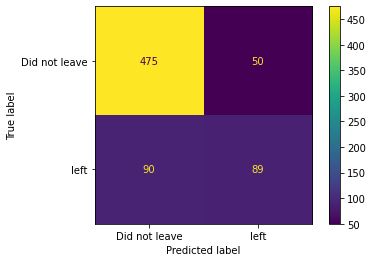

In [329]:
plot_confusion_matrix(clf_xgb,
                      X_test,
                      y_test,
                      values_format='d',
                      display_labels=['Did not leave','left'])

525 people did not leave 
475 were corectly classified
179 left the company
the boost model is not good the data is imbalanced we are going to use tye scale_pos_weight

In [330]:
#OPTIMISATION USING CROSS VALIDATION AND GRID SEARCH
clf_xgb=xgb.XGBClassifier(seed=42,
                          objective='binary:logistic',
                          learn_rate=0.1,
                          gamma=0.25,
                          max_depth=4,
                          reg_lambda=10,
                          scale_pos_weight=3,
                          sub_sample=0.9,
                          colsample_bytree=0.5
                          )


In [331]:
clf_xgb.fit(X_train,
            y_train,
            verbose=True,
            early_stopping_rounds=10,
            eval_metric='aucpr',
            eval_set=[(X_test,y_test)])

[0]	validation_0-aucpr:0.575753
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.573395
[2]	validation_0-aucpr:0.578449
[3]	validation_0-aucpr:0.576319
[4]	validation_0-aucpr:0.63255
[5]	validation_0-aucpr:0.633141
[6]	validation_0-aucpr:0.638422
[7]	validation_0-aucpr:0.636721
[8]	validation_0-aucpr:0.619736
[9]	validation_0-aucpr:0.62508
[10]	validation_0-aucpr:0.630796
[11]	validation_0-aucpr:0.633098
[12]	validation_0-aucpr:0.640476
[13]	validation_0-aucpr:0.639167
[14]	validation_0-aucpr:0.642794
[15]	validation_0-aucpr:0.641094
[16]	validation_0-aucpr:0.637777
[17]	validation_0-aucpr:0.641386
[18]	validation_0-aucpr:0.647364
[19]	validation_0-aucpr:0.64487
[20]	validation_0-aucpr:0.644375
[21]	validation_0-aucpr:0.642645
[22]	validation_0-aucpr:0.641371
[23]	validation_0-aucpr:0.646655
[24]	validation_0-aucpr:0.650321
[25]	validation_0-aucpr:0.650674
[26]	validation_0-aucpr:0.654952
[27]	validation_0-aucpr:0.654101
[28]	validation_0-aucpr

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0.25,
              learn_rate=0.1, learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=10, scale_pos_weight=3, seed=42,
              silent=None, sub_sample=0.9, subsample=1, verbosity=1)

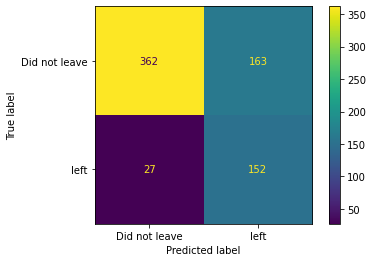

In [332]:
plot_confusion_matrix(clf_xgb,
                      X_test,
                      y_test,
                      values_format='d',
                      display_labels=['Did not leave','left'])